# LLM Zoomcamp - Week 4 Notes

A quick recap of what the first three sections have been about:
- Let's chart with the visual of what we created and map it back to our `rag` function:
  ```mermaid
    graph TD
        A[User] -->|Q| B[Knowledge DB]
        B -->|Relevant Documents D1, D2, ..., DN| C[Context = Prompt + Q + Documents]
        A -->|Q| C
        C -->|Q| D[LLM]
        D -->|Answer| A
        subgraph Context
            direction LR
            D1
            D2
            D3
            D4
            ...
            DN
        end
        B -.-> D1
        B -.-> D2
        B -.-> D3
        B -.-> D4
        B -.-> ...
        B -.-> DN
        classDef entity fill:#f9f,stroke:#333,stroke-width:4px;
    ```
  - and the function itself was:
    ```python
    def rag(query):
      search_results = search(query)
      prompt = prompt_builder(query, search_results)
      answer = llm(prompt)
      return answer
    ```
- In section 1:
  - We built the scaffold for the function above
  - We learned all about what a RAG is, how to apply a common "search" problem using a source document as context, how to implement one using OpenAI's GPT models, and how to use Elasticsearch to do "semantic" or "keyword" search to simplify the size of the documents being passed to the LLM
- In section 2:
  - We implemented various versions of the `llm` function
  - We focused further on self-hosted LLMs and how to effectively replicate everything we did in section 1 but using `ollama` as a platform to access self-hosted models
  - I further set up my windows gaming PC to act as a server running 3 containers: `ollama`, `openwebui` and `elasticsearch` in order to have "always on" access to these services
- In section 3:
  - We experimented with various implementations of the `search` function
  - We switched from doing a straight "semantic" or "keyword" search using Elasticsearch to creating embeddings in order to do vector search. The main difference here is that instead of relying on Elasticsearch's Lucine engine to look up relevant documents based on a text query, we were using various `encoding` algorithms like cosine distance, SBERT models, etc.
  - We then built a ground-truth dataset using LLMs in order to evaluate the quality of our retrieval system and compared the performance of "semantic" search and "vector" search in retrieving the most relevant documents for a given query

In this section the focus is on the following:
- Extending the evaluation work we did in section 3 to monitor answer quality over time
- How to look at answer quality with user feedback and interaction
- How to store all this data and visualize it, etc.

## 4.1 Intro

- Monitoring RAG systems is done primarily to guarantee the quality of outputs don't degrade over time
- The steps to monitor answer quality of LLMs is comprised of a few steps:
  - Compute various kinds of quality metrics, such as:
    - Vector similarity between an expected or ideal answer and the one the LLM produces
    - Using LLMs as judges to assess "toxicity" of the answer it provides
      - We can use pre-trained models that specialize at assessing "toxicity" from Huggingface
    - Using LLM as judges to assess the quality of the answer it provides
  - Store all these metrics in a relational database
    - We'll be using `postgres` to store all this data deployed in a docker container
  - Using tools like `Grafana` to visualize metrics over time
  - Incorporate a user feedback loop to collect user feedback
    - We'll also use Grafana to visualize this
- There are other things one could monitor:
  - Other quality metrics like: bias/fairness, topic clustering, textual user feedback (vs binary or categorical)
  - System metrics like the 4x golden signals: latency, traffic, errors (especially those a user sees), and saturation (CPU/GPU usage)
  - Cost metrics: token and infra costs of running vector stores and LLMs

## 4.2 Differences Between Online and Offline Evaluation (with RAGs)
- Building on the steps from the previous sections, now we're going to construct evaluation for the entire RAG system
  - How good is retrieval? How good is our prompt? Which LLM works best?
- There are generally two types of evaluation:
  - Offline:
    - Evaluating the quality of a system before deploying it
    - In the case of the previous section, we experimented with different retrieval techniques and measured `hit rate` and `mrr` before selecting a method that produced the best results
  - Online
    - Evaluating the quality of a system after it's been deployed
    - For example, running A/B tests between two different system configurations, user feedback
- In a related sense, we have monitoring, where we observe the overall health of the system:
  - User feedback on how good the answer is, etc.

### Techniques For Offline Evaluation
- Examples of techniques:
  - Cosine similarity: Evaluating how close the response from an LLM is to a ground truth dataset
    - In section 3, for example, we ran a workflow like this:
      - `answer_original -> create questions -> answer_llm`
      - So we compared `cosine(answer_original, answer_llm)` in order to assess how well our retrieval system was at retrieving relevant documents to our questions
  - LLM as a judge
    - We can also compute the similarity by asking the LLM to tell us!
    - So instead of using cosine similarity, we can create a function like this: `llm_judge(answer_original, answer_llm)`
    - In certain cases, where we don't actually have an original answer (i.e. it's not in our ground truth dataset), we can compute something like this: `llm_judge(question, answer_llm)` where we ask it to tell us how good an answer is to the question provided
- In a similar sense, we can also compute the quality not just of the retrieved documents / answers to a question, but if our LLM is creating an answer using retrieved documents as context, we can also measure how well the LLM writes its own answer

## 4.3 Offline Evaluation for our RAG System

- So now we're going to build the evaluation system for our entire RAG system
  - That is, we are going to evaluate how well our `answer = llm(prompt)` part answers the question
- So let's start by bringing in all the various components of our previous system:

### Load our FAQ documents with document IDs

In [29]:
import requests

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

### Load ground truth dataset we create using LLMs

In [21]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
gt_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(gt_url)
## filter to machine learning zoomcamp only
df_ground_truth = df_ground_truth[df_ground_truth['course'] == 'machine-learning-zoomcamp']
## convert to dictionary
ground_truth = df_ground_truth.to_dict(orient='records')

In [22]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [28]:
## re-index the document to have the document id be the key and the quesetion/course be the value
doc_index = {d['id']: d for d in documents}
print(doc_index['5170565b']['text'])

Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.


- Now, we index the data based on the most successful vector search approach we evaluated in the previous section
- Let's recall that the best approach was the one where we embedded a concatenation of the `question` and `text` vs just either alone
- So let's go through all the steps now to initiate our Elasticsearch database, create our embeddings and index them

In [5]:
## Load a pre-trained embedding model
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [6]:
## Set up your elasticsearch client
from elasticsearch import Elasticsearch
es_client = Elasticsearch("http://192.168.50.49:9200")

In [7]:
es_client.info()

ObjectApiResponse({'name': 'b3a351c3296c', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'OJZEGlS9RR6yoR11cShgug', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [8]:
## define the schema for the index
## we will use concated question and text

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },

        }
    }
}

index_name = "course-questions"

if es_client.indices.exists(index=index_name):
    es_client.indices.delete(index=index_name)
    print(f"Index {index_name} deleted.")

es_client.indices.create(index=index_name, body=index_settings)
print(f"Index {index_name} created.")

Index course-questions deleted.
Index course-questions created.


In [10]:
## Create the embeddings for question_text_vector and index them in elasticsearch

from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, body=doc)

100%|██████████| 948/948 [01:36<00:00,  9.83it/s]


In [11]:
def elastic_search_knn(user_query, query_vector, course_filter):
    # Define the KNN query
    knn_query = {
        "field": user_query,
        "query_vector": query_vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course_filter
            }
        }
    }

    search_query = {
        "knn": knn_query,
        "_source": ["text", "section", "question", "course", "id"]
    }

    # Execute the KNN search
    es_results = es_client.search(index=index_name,
                           body=search_query
    )

    result_docs = []
    
    # Extract the relevant documents from the search results
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn("question_text_vector", v_q, course)

In [13]:
question_text_vector_knn(dict(
    question = "Are sessions recorded if I miss one?",
    course = "machine-learning-zoomcamp"
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

Now we can build our original rag function, but this time, instead of using a semantic search, we'll use our `question_text_bector_knn` function in order to produce results for rettrieval

In [19]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()

    return prompt

In [16]:
from openai import OpenAI

client = OpenAI()

In [35]:
def llm(prompt, model="gpt-4o"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user",
             "content": prompt}
        ]
    )
    return response.choices[0].message.content

In [51]:
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [23]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [39]:
rag(ground_truth[10])

'Yes, sessions are recorded if you miss one. You will still have access to everything that was covered and can also ask questions in advance for office hours or in Slack.'

In [31]:
doc_index['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

### Cosine Similarity metric
- Now that we have the original answer and the answer produced by an LLM, we can compute a similarity metric
- To do that, we need to create embeddings out of both answers we have

In [34]:
answer_orig = rag(ground_truth[10])
answer_llm = doc_index['5170565b']['text']

print(answer_orig)
print(answer_llm)

v_orig = model.encode(answer_orig)
v_llm = model.encode(answer_llm)

v_llm.dot(v_orig)

Yes, sessions are recorded if you miss one. Everything is recorded, including office hours, so you won’t miss any content. You can ask your questions for office hours in advance, and these will be addressed during the live stream. Additionally, you can always ask questions in Slack.
Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.


0.80153173

- Now we're ready to iterate over the entire set of questions in the ground_truth dataset, we can produce an answer from the LLM
- And then for each answer produced, we can compute the similarity metric between it and the original answer
- Let's try running it once with GPT-4o and then again with GPT-4o-mini to see the results and cost difference

In [95]:
answers = {}

In [49]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    answer_llm = rag(rec, model='gpt-4o-mini')

    doc_id = rec['document']
    original_doc = doc_index[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document_id': doc_id,
        'question': rec['question'],
        'course': rec['course']
    }

100%|██████████| 1830/1830 [1:21:13<00:00,  2.66s/it]


In [52]:
## Let's put it into a dictionary where each of the fields we care about is the key:

results_gpt4o_mini = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o_mini[i] = val.copy()
    results_gpt4o_mini[i].update(ground_truth[i])  # merge the two dictionaries

Let's export this data to a csv for now before we go back and re-run this with gpt-4o or an alternative model

In [59]:
import pandas as pd
df_gpt4o_mini = pd.DataFrame(results_gpt4o_mini)
!mkdir data
df_gpt4o_mini.to_csv('data/results_gpt4o_mini.csv', index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


- Ok, now before we go ahead and run this same code with another model, let's first implement some multi-threading so we can call the OpenAI API in parallel to speed up the processing
- Oh! and by the way, gpt-4o-mini cost wayyyyyy less than running even a fraction of gpt-4o. However, from a time perspective, it took 1h:21m to run the whole thing which is really slow. I'm curious how long it'd take to run gpt-3.5-turbo, or gpt-4o for that matter...
- 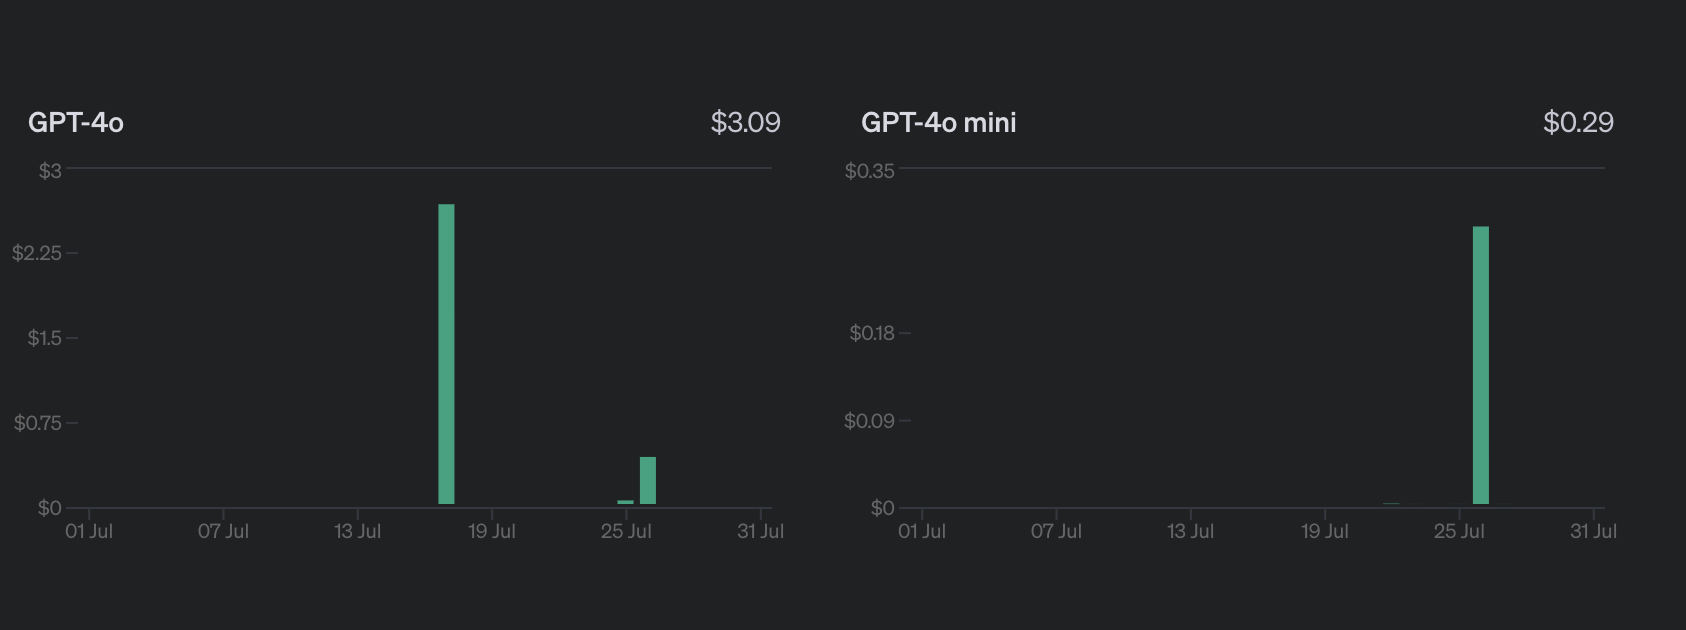

### Evaluating GPT-3.5-turbo vs GPT-4o-mini
- Let's run the same thing as above but by just changing the model we use from `gpt-4o-mini` to `gpt-3.5-turbo`
- Before we do that, let's copy in the code to run this process in parallel
  - A few important things to note with this code:
    - How it works: 
      - It's basically just applying a function `f` to a iterable sequence of elements `seq` in parallel
      - Some notes on `max_workers`:
        1. It sets the number of workers to 6, which might be too high or low. The main considerations for this parameter are:
           1. CPU Cores. It shouldn't exceed the number of CPU Cores. You can run `sysctl -n hw.ncpu` to find out
           2. Make sure the tasks you're running in the function `f` aren't CPU bound. If the tasks are I/O bound, you can benefit from having more workers
           3. Overall load on your system. More workers means more load, means your system becomes unusable
- Ok, let's go!

In [64]:
!sysctl -n hw.ncpu

8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [88]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [90]:
## Let's take our code from above and put it into a function that we can use with map_progress
## We'll parameterize the model here as well

def process_record(rec, model='gpt-4o-mini'):
    
    answer_llm = rag(rec, model=model)

    doc_id = rec['document']
    original_doc = doc_index[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document_id': doc_id,
        'question': rec['question'],
        'course': rec['course']
    }

In [84]:
process_record(ground_truth[5])

{'answer_llm': 'The course videos are pre-recorded, so you can start watching them right now.',
 'answer_orig': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
 'document_id': '39fda9f0',
 'question': 'Are the course videos live or pre-recorded?',
 'course': 'machine-learning-zoomcamp'}

In [85]:
from functools import partial

process_record_withmodel = partial(process_record, model='gpt-3.5-turbo')

In [98]:
## Set the number of workers to use (see note above on how to set this)
# pool = ThreadPoolExecutor(max_workers=1)
# results_gpt35turbo = map_progress(pool, ground_truth, process_record_withmodel)

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    answer_llm = rag(rec, model='gpt-3.5-turbo')

    doc_id = rec['document']
    original_doc = doc_index[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document_id': doc_id,
        'question': rec['question'],
        'course': rec['course']
    }

  0%|          | 0/1830 [00:17<?, ?it/s]


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-eIKGSFHll2tdA0DA5cB4dKva on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}

In [ ]:
results_gpt35_turbo = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt35_turbo[i] = val.copy()
    results_gpt35_turbo[i].update(ground_truth[i])  # merge the two dictionaries

- I keep hitting API rate limits with the code above so I'm going to change the max_workers back to 1 just to avoid this...
- I need to implement some kind of retry capability. ChatGPT suggests using `tenacity` and applying some retry logic to the API call

In [ ]:
df_gpt35_turbo = pd.DataFrame(results_gpt35turbo)
df_gpt35_turbo.to_csv('data/results_gpt35_turbo.csv', index=False)

## 4.4 Offline RAG Evaluation - Cosine Similarity



In [2]:
# TODO

## 4.5 Offline RAG Evaluation - LLM as a Judge



In [3]:
# TODO

## 4.6 Capturing User Feedback



In [4]:
# TODO

## 4.7 Monitoring the System



In [5]:
# TODO